In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


228827136/228813984 [==============================] - 46s 0us/step


In [3]:
image_count = len(list(c.glob('*/*.jpg')))
print(image_count)


3670


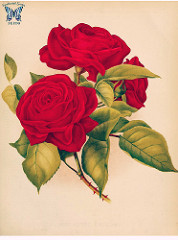

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


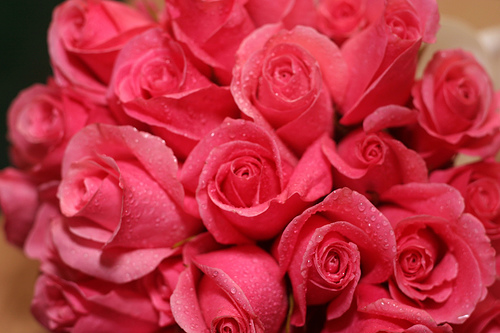

In [6]:
PIL.Image.open(str(roses[1]))
#print(len(roses))

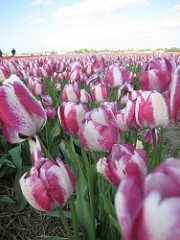

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


In [8]:
#Create a dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-12-27 17:31:45.444852: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


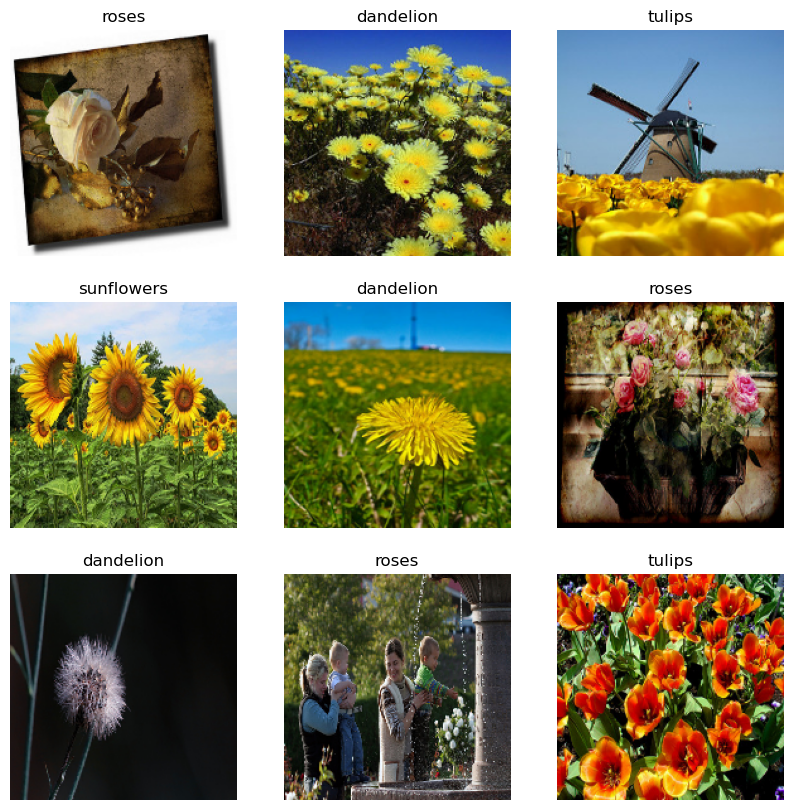

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [26]:
print(type(image_batch))
im_bat_array = image_batch.numpy()
lab_bat_array = labels_batch.numpy()
print(len(im_bat_array))
print(type(im_bat_array))
print(im_bat_array.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
32
<class 'numpy.ndarray'>
(32, 180, 180, 3)


In [28]:
print(class_names[3])
print(lab_bat_array[3])
print(class_names[lab_bat_array[3]])

sunflowers
4
tulips


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
normalization_layer = layers.Rescaling(1./255)


In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [32]:
# A basic Keras model
## Create the model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [33]:
## Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [35]:
## Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10


2023-12-27 18:10:47.984470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66355200 exceeds 10% of free system memory.
2023-12-27 18:10:49.735415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66355200 exceeds 10% of free system memory.


 1/92 [..............................] - ETA: 5:15 - loss: 1.5715 - accuracy: 0.3438

2023-12-27 18:10:50.178736: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66355200 exceeds 10% of free system memory.
2023-12-27 18:10:51.243463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66355200 exceeds 10% of free system memory.


 2/92 [..............................] - ETA: 2:17 - loss: 2.4461 - accuracy: 0.2812

2023-12-27 18:10:51.683350: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66355200 exceeds 10% of free system memory.


92/92 [==============================] - 133s 1s/step - loss: 1.4728 - accuracy: 0.3798 - val_loss: 1.1846 - val_accuracy: 0.5150
Epoch 2/10
92/92 [==============================] - 129s 1s/step - loss: 1.0608 - accuracy: 0.5811 - val_loss: 1.0522 - val_accuracy: 0.5586
Epoch 3/10
92/92 [==============================] - 133s 1s/step - loss: 0.8845 - accuracy: 0.6638 - val_loss: 1.0936 - val_accuracy: 0.5777
Epoch 4/10
92/92 [==============================] - 135s 1s/step - loss: 0.7143 - accuracy: 0.7333 - val_loss: 1.0293 - val_accuracy: 0.5913
Epoch 5/10
92/92 [==============================] - 135s 1s/step - loss: 0.5488 - accuracy: 0.8028 - val_loss: 0.9645 - val_accuracy: 0.6076
Epoch 6/10
92/92 [==============================] - 134s 1s/step - loss: 0.3338 - accuracy: 0.8910 - val_loss: 1.1227 - val_accuracy: 0.6104
Epoch 7/10
92/92 [==============================] - 135s 1s/step - loss: 0.1887 - accuracy: 0.9394 - val_loss: 1.2410 - val_accuracy: 0.6417
Epoch 8/10
92/92 [======

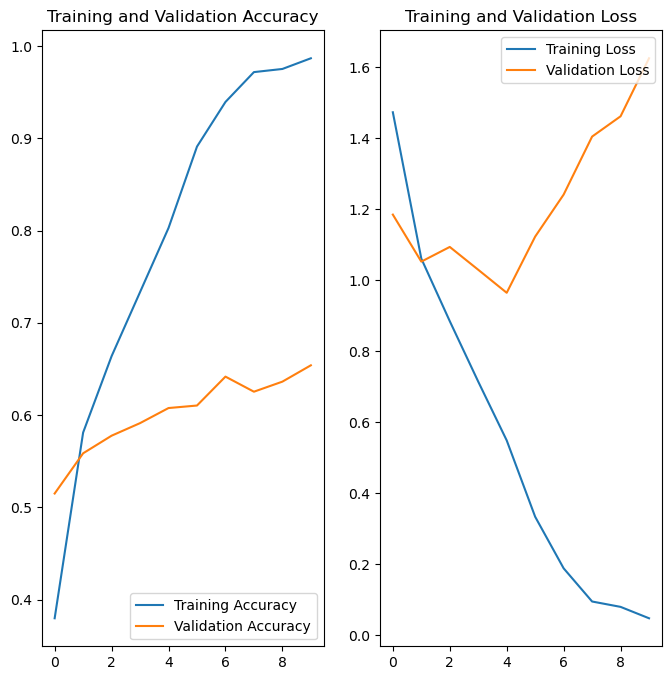

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [41]:
# Reducing over fitting
## Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


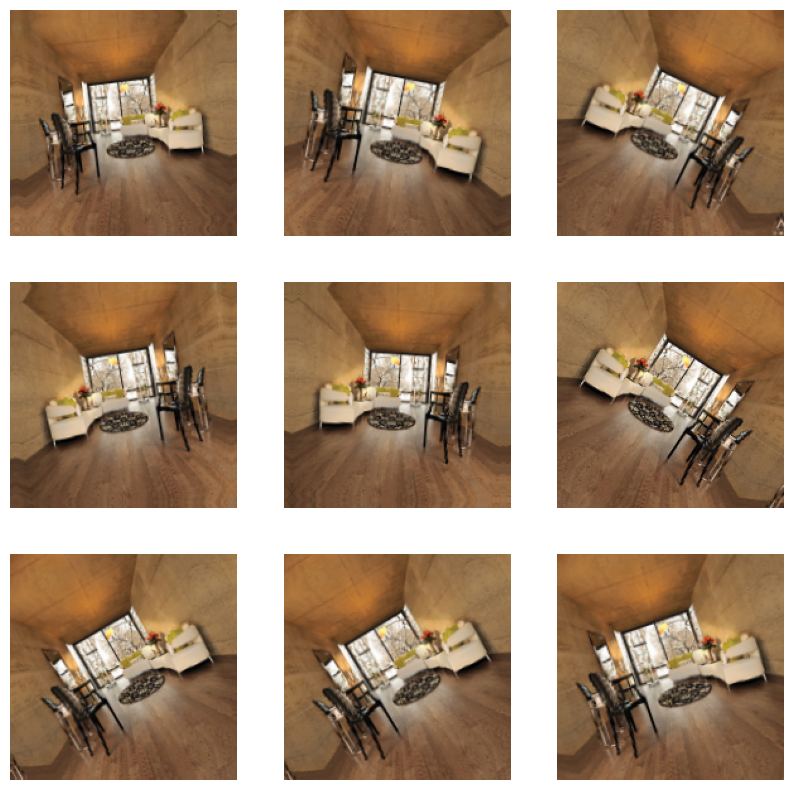

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [43]:
## Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [45]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [46]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 139s 1s/step - loss: 1.3134 - accuracy: 0.4404 - val_loss: 1.1327 - val_accuracy: 0.5640
Epoch 2/15
92/92 [==============================] - 123s 1s/step - loss: 1.0214 - accuracy: 0.5995 - val_loss: 0.9940 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 114s 1s/step - loss: 0.9148 - accuracy: 0.6461 - val_loss: 0.8640 - val_accuracy: 0.6757
Epoch 4/15
92/92 [==============================] - 151s 2s/step - loss: 0.8634 - accuracy: 0.6700 - val_loss: 0.8413 - val_accuracy: 0.6703
Epoch 5/15
92/92 [==============================] - 152s 2s/step - loss: 0.7954 - accuracy: 0.6962 - val_loss: 0.8726 - val_accuracy: 0.6798
Epoch 6/15
92/92 [==============================] - 151s 2s/step - loss: 0.7399 - accuracy: 0.7224 - val_loss: 0.7809 - val_accuracy: 0.7057
Epoch 7/15
92/92 [==============================] - 151s 2s/step - loss: 0.7051 - accuracy: 0.7340 - val_loss: 0.7683 - val_accuracy: 0.7003
Epoch 8/15
92

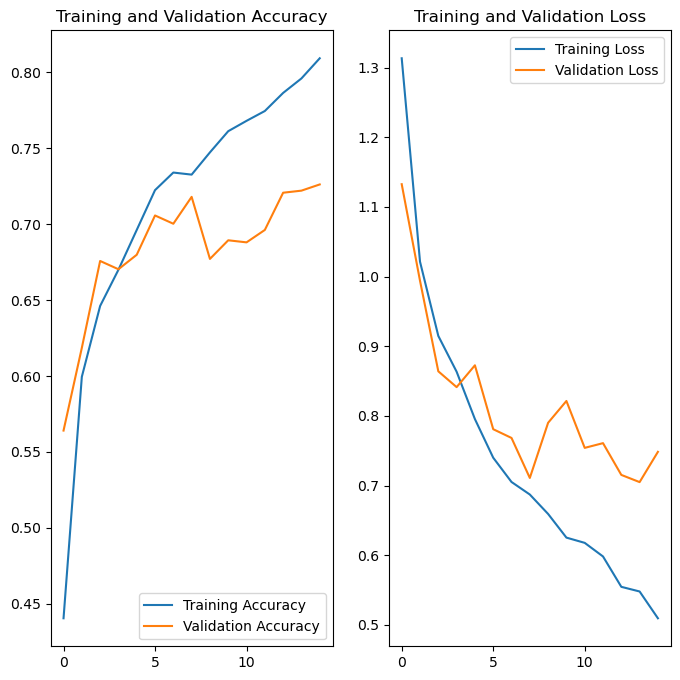

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
